In [ ]:
! pip install -q langgraph langchain-community langchain-core langchain-groq

In [ ]:
from langchain_groq import ChatGroq
import os
from google.colab import userdata

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode


In [ ]:
GROQ_API_KEY = userdata.get('GROQ_API_KEY')

os.environ["GROQ_API_KEY"] = GROQ_API_KEY

In [ ]:
llm = ChatGroq(model="qwen-2.5-32b")

In [ ]:
llm.invoke("Hi").content

'Hello! How can I assist you today? Feel free to ask any questions or let me know if you need help with anything specific.'

In [ ]:
def assistant(state:MessagesState):
  messages = state["messages"]
  response = llm.invoke(messages)
  return {"messages":[response.content]}

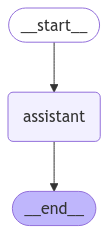

In [ ]:
workflow = StateGraph(MessagesState)

workflow.add_node("assistant",assistant)
workflow.add_edge(START,"assistant")
workflow.add_edge("assistant",END)

graph = workflow.compile()
graph

In [ ]:
graph.invoke({"messages":"Hi"})

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='47603c71-b50b-4e9f-bd38-995d10880723'),
  HumanMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='7f98eb63-7be6-4fe7-96dc-c6ad4acfe559')]}

In [ ]:
for output in graph.stream({"messages":"Hi"}):
  for key,value in output.items():
    print(f"{key}: {value}")

assistant: {'messages': ['Hello! How can I assist you today?']}


In [ ]:
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

In [ ]:
search.invoke("What is temp in San Francisco")

"It's 60 degrees and foggy."

In [ ]:
search.invoke("What is temp in Mumbai")

"It's 90 degrees and sunny."

In [ ]:
search

StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x784612bb1580>)

In [ ]:
tools = [search]

In [ ]:
tool_node = ToolNode(tools)

In [ ]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x784612cd22d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x784612ce49d0>, model_name='qwen-2.5-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'search', 'description': 'this is my custom tool.', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [ ]:
def assistant(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

print(assistant({"messages":"Hi"}))
print(assistant({"messages":"what is temp in sf"}))

{'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 161, 'total_tokens': 171, 'completion_time': 0.05, 'prompt_time': 0.009935948, 'queue_time': 0.203049795, 'total_time': 0.059935948}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-8b39f3bc-4733-457d-90b1-39fb07effe28-0', usage_metadata={'input_tokens': 161, 'output_tokens': 10, 'total_tokens': 171})]}
{'messages': [AIMessage(content="To provide you with the current temperature in San Francisco, I would need to use a weather API or service. However, with the tools provided to me, I can't directly fetch live weather data. Instead, I can help you with general information or guide you on how to find the current temperature using online resources. Would you like that, or is there something specific about San Francisco's climate you're interested in?",

In [ ]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

In [ ]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", assistant)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

In [ ]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='5899ae92-4cd7-4ca5-8c2f-7a92223e1950'),
  AIMessage(content="Hello! I'm an AI and don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 165, 'total_tokens': 195, 'completion_time': 0.15, 'prompt_time': 0.010611403, 'queue_time': 0.202962479, 'total_time': 0.160611403}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-ef1ba8e1-85b2-4421-a693-79b558c732d0-0', usage_metadata={'input_tokens': 165, 'output_tokens': 30, 'total_tokens': 195})]}

In [ ]:
app.invoke({"messages": ["What is temp in sf"]})

{'messages': [HumanMessage(content='What is temp in sf', additional_kwargs={}, response_metadata={}, id='5bd7a292-e58e-456f-904d-6b3a334a2461'),
  AIMessage(content="To provide you with the current temperature in San Francisco, I would need to use a weather API or a search function that can fetch this information. Since I don't have direct access to weather APIs here, could you please confirm if you want me to use the search tool to look this up online?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 165, 'total_tokens': 226, 'completion_time': 0.305, 'prompt_time': 0.009936578, 'queue_time': 0.198917272, 'total_time': 0.314936578}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-0afd0aa6-886c-40dc-bd20-37d4251cecba-0', usage_metadata={'input_tokens': 165, 'output_tokens': 61, 'total_tokens': 226})]}

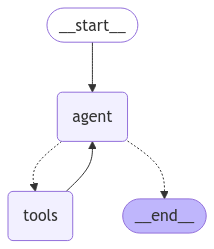

In [ ]:
def assistant(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", assistant)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})
workflow.add_edge("tools","agent")
app = workflow.compile()
app

In [ ]:
app.invoke({"messages": ["What is temp in San Francisco"]})

{'messages': [HumanMessage(content='What is temp in San Francisco', additional_kwargs={}, response_metadata={}, id='126f049c-f61f-4f7c-99af-9f942248f111'),
  AIMessage(content="To provide you with the current temperature in San Francisco, I would need to use a weather API or service. However, with the tool provided, we can't directly fetch weather data. But if you want, I can search for a reliable source where you can find this information. Would you like that?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 166, 'total_tokens': 228, 'completion_time': 0.31, 'prompt_time': 0.010181948, 'queue_time': 0.201602375, 'total_time': 0.320181948}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-1bfaf51f-4685-42ef-9ee6-33f962b5f6c1-0', usage_metadata={'input_tokens': 166, 'output_tokens': 62, 'total_tokens': 228})]}

In [ ]:
memory = MemorySaver()

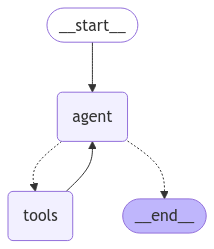

In [ ]:
def assistant(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", assistant)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})
workflow.add_edge("tools","agent")
app = workflow.compile(checkpointer=memory)
app

In [ ]:
config = {"thread_id":"1"}
app.invoke({"messages": ["What is temp in San Francisco"]},config=config)

{'messages': [HumanMessage(content='What is temp in San Francisco', additional_kwargs={}, response_metadata={}, id='eba532a9-3a5e-4258-8357-4144cb6484ac'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bt0t', 'function': {'arguments': '{"query": "current temperature in San Francisco"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 166, 'total_tokens': 238, 'completion_time': 0.36, 'prompt_time': 0.010185761, 'queue_time': 0.19958260200000003, 'total_time': 0.370185761}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b8e6b739-67b9-4990-a2e5-20b8cfc08e3f-0', tool_calls=[{'name': 'search', 'args': {'query': 'current temperature in San Francisco'}, 'id': 'call_bt0t', 'type': 'tool_call'}], usage_metadata={'input_tokens': 166, 'output_tokens': 72, 'total_tokens': 238}),
  ToolMessage(content="It's 60 degrees and fo